### Importing libraries

In [5]:
#Importing file paths
import os

#For managing dataframe
import pandas as pd
import numpy as np

#PyTorch
import torchaudio
import torch
from torch.utils.tensorboard import SummaryWriter
from torch.utils.data import Dataset
from torch import nn

#Metrics
import seaborn as sb
import matplotlib.pyplot as plt
from torchmetrics.classification import MulticlassF1Score
from torchmetrics.classification import ConfusionMatrix

# Misc.
import PIL
import cv2
import warnings
import torchvision
from sklearn.model_selection import train_test_split
from sklearn.utils.class_weight import compute_class_weight
from sklearn.preprocessing import StandardScaler
from tqdm.notebook import tqdm_notebook

warnings.filterwarnings("ignore")

#Selecting device
device="cuda" if torch.cuda.is_available() else "cpu"

print(f"Using {device}")

Using cuda


### Image

In [8]:
im1=cv2.imread("sample_image_01.png")
im2=cv2.imread("sample_image_02.png")
print(im1.shape)
print(im2.shape)

(2359, 1665, 3)
(2448, 1665, 3)


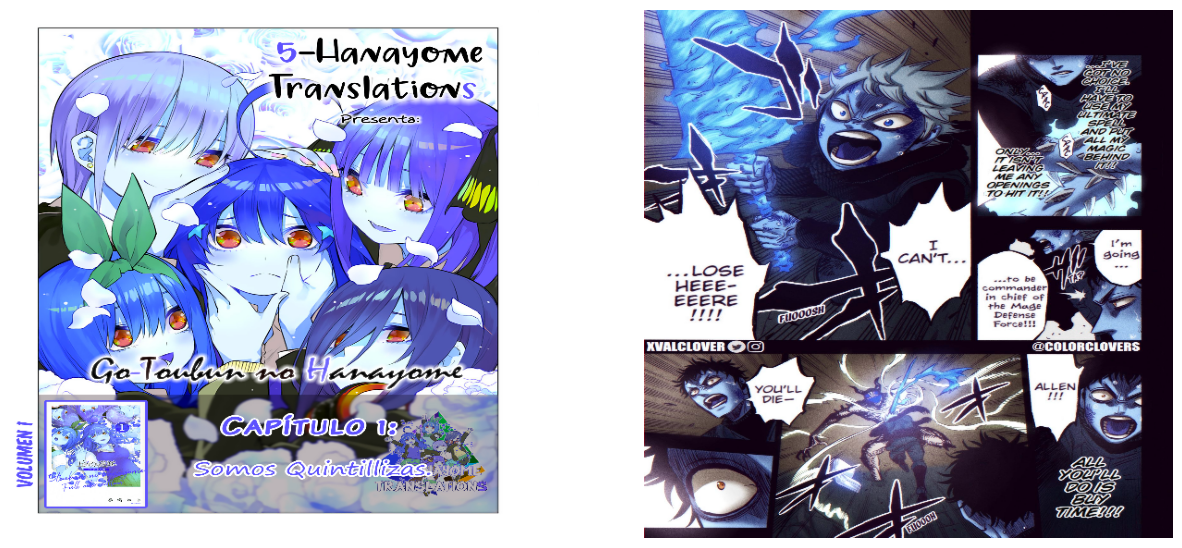

In [31]:
plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis(False)
plt.imshow(cv2.resize(im1,(572,572)))
plt.subplot(1,2,2)
plt.axis(False)
plt.imshow(cv2.resize(im2,(572,572)))